In [1]:
import HARK.ConsumptionSaving.ConsPortfolioFrameModel as cpfm
import HARK.ConsumptionSaving.ConsPortfolioModel as cpm
from HARK.frame import Frame, draw_frame_model
from HARK.rewards import (
    CRRAutility,
)

The `FrameAgentType` is an alternative way to specify a model.

The library contains a demonstration of this form of model, `ConsPortfolioFrameModel`, which is a replica of the `ConsPortfolioModel`.

This notebook compares the results of simulations of the two models.

In [2]:
pct = cpm.PortfolioConsumerType(T_sim=5000, AgentCount=200)
pct.cycles = 0

# Solve the model under the given parameters

pct.solve()
pct.track_vars += [
    "mNrm",
    "cNrm",
    "Share",
    "aNrm",
    "Risky",
    "Adjust",
    "PermShk",
    "TranShk",
    "bNrm",
    "who_dies",
]

pct.make_shock_history()
pct.read_shocks = True

pct.initialize_sim()

pct.simulate()

{'mNrm': array([[ 1.42660498,  2.30216168,  1.60391177, ...,  1.41755556,
          1.12557298,  1.63660913],
        [ 1.51463426,  1.93229161,  0.74937478, ...,  1.27321053,
          1.10738657,  1.71573911],
        [ 1.46382598,  1.7045285 ,  1.07642321, ...,  1.58156597,
          1.2941777 ,  1.58746016],
        ...,
        [35.85154922,  3.87504927,  3.59044371, ..., 18.15164449,
         16.07506874,  1.47628601],
        [38.91576236,  4.27825616,  3.76022763, ..., 18.00301806,
         15.91187529,  1.61918815],
        [31.64511794,  3.42226862,  3.47249399, ..., 14.11097207,
         13.29840192,  1.48801267]]),
 'cNrm': array([[0.92439082, 1.06319404, 0.96157085, ..., 0.92229283, 0.84011148,
         0.96768669],
        [0.94381288, 1.01520108, 0.66391146, ..., 0.88532205, 0.83386309,
         0.98159191],
        [0.93284878, 0.97967458, 0.82282501, ..., 0.95732218, 0.89106445,
         0.95848444],
        ...,
        [3.31817794, 1.22252973, 1.19622642, ..., 2.2391

In [3]:
pcft = cpfm.PortfolioConsumerFrameType(T_sim=5000, AgentCount=200, read_shocks=True)

pcft.cycles = 0

# Solve the model under the given parameters
pcft.solve()

pcft.track_vars += [
    "mNrm",
    "cNrm",
    "Share",
    "aNrm",
    "Adjust",
    "PermShk",
    "TranShk",
    "bNrm",
    "U",
]

pcft.shock_history = pct.shock_history
pcft.newborn_init_history = pct.newborn_init_history

pcft.initialize_sim()

pcft.simulate()

Finished cycle #1 in 0.013799428939819336 seconds, solution distance = 100.0
Finished cycle #2 in 0.016463518142700195 seconds, solution distance = 51.348207181883055
Finished cycle #3 in 0.015204191207885742 seconds, solution distance = 17.087772635804413
Finished cycle #4 in 0.016463041305541992 seconds, solution distance = 8.522764942790392
Finished cycle #5 in 0.01439523696899414 seconds, solution distance = 5.096872874136956
Finished cycle #6 in 0.014560937881469727 seconds, solution distance = 3.3840571487090756
Finished cycle #7 in 0.014954566955566406 seconds, solution distance = 2.4054860139035092
Finished cycle #8 in 0.014110565185546875 seconds, solution distance = 1.7940793244431177
Finished cycle #9 in 0.013866186141967773 seconds, solution distance = 1.3867304233120308
Finished cycle #10 in 0.013986587524414062 seconds, solution distance = 1.1015802993548078
Finished cycle #11 in 0.014078140258789062 seconds, solution distance = 0.894235485037818
Finished cycle #12 in 0.0

Finished cycle #15 in 0.014366626739501953 seconds, solution distance = 0.4504802092849225
Finished cycle #16 in 0.01435089111328125 seconds, solution distance = 0.3896272258302673
Finished cycle #17 in 0.014223814010620117 seconds, solution distance = 0.3395825834143551
Finished cycle #18 in 0.014173269271850586 seconds, solution distance = 0.29794670047725447
Finished cycle #19 in 0.013914346694946289 seconds, solution distance = 0.26295053927306533
Finished cycle #20 in 0.013898372650146484 seconds, solution distance = 0.23326714495567913
Finished cycle #21 in 0.014075756072998047 seconds, solution distance = 0.20788551415958523
Finished cycle #22 in 0.01383066177368164 seconds, solution distance = 0.18602381540941515
Finished cycle #23 in 0.01381540298461914 seconds, solution distance = 0.16707072712179638
Finished cycle #24 in 0.013994693756103516 seconds, solution distance = 0.15054159770340902
Finished cycle #25 in 0.014000415802001953 seconds, solution distance = 0.136049088797

Finished cycle #30 in 0.014490604400634766 seconds, solution distance = 0.08496273987111991
Finished cycle #31 in 0.014397621154785156 seconds, solution distance = 0.07776503617679964
Finished cycle #32 in 0.013854265213012695 seconds, solution distance = 0.07128414952298101
Finished cycle #33 in 0.013744831085205078 seconds, solution distance = 0.06543328277846072
Finished cycle #34 in 0.01404571533203125 seconds, solution distance = 0.06013774194589416
Finished cycle #35 in 0.014039039611816406 seconds, solution distance = 0.05533406288701315
Finished cycle #36 in 0.013898372650146484 seconds, solution distance = 0.05094857000406705
Finished cycle #37 in 0.014035224914550781 seconds, solution distance = 0.04696866348405759
Finished cycle #38 in 0.013510704040527344 seconds, solution distance = 0.04335051680341451
Finished cycle #39 in 0.013619422912597656 seconds, solution distance = 0.0400424441635181
Finished cycle #40 in 0.013711214065551758 seconds, solution distance = 0.03701281

Finished cycle #45 in 0.014046430587768555 seconds, solution distance = 0.025192441992402337
Finished cycle #46 in 0.014653205871582031 seconds, solution distance = 0.023359687115785732
Finished cycle #47 in 0.014449834823608398 seconds, solution distance = 0.02166848131533783
Finished cycle #48 in 0.015507221221923828 seconds, solution distance = 0.02010663614227326
Finished cycle #49 in 0.015063285827636719 seconds, solution distance = 0.018663202643659282
Finished cycle #50 in 0.015668630599975586 seconds, solution distance = 0.01732830607049607
Finished cycle #51 in 0.015999555587768555 seconds, solution distance = 0.016093003159316055
Finished cycle #52 in 0.014594078063964844 seconds, solution distance = 0.014949195437637286
Finished cycle #53 in 0.014731645584106445 seconds, solution distance = 0.013889565521708391
Finished cycle #54 in 0.01469564437866211 seconds, solution distance = 0.012907444485231068
Finished cycle #55 in 0.01454925537109375 seconds, solution distance = 0.0

Finished cycle #59 in 0.014119386672973633 seconds, solution distance = 0.00896425655221833
Finished cycle #60 in 0.01456594467163086 seconds, solution distance = 0.008336490713726441
Finished cycle #61 in 0.014174699783325195 seconds, solution distance = 0.0077532217486293575
Finished cycle #62 in 0.014234542846679688 seconds, solution distance = 0.007211170345946094
Finished cycle #63 in 0.014397144317626953 seconds, solution distance = 0.006707318939021434
Finished cycle #64 in 0.014032125473022461 seconds, solution distance = 0.006238887886780731
Finished cycle #65 in 0.013937711715698242 seconds, solution distance = 0.005803339284177866
Finished cycle #66 in 0.014064788818359375 seconds, solution distance = 0.005398303113523184
Finished cycle #67 in 0.014114856719970703 seconds, solution distance = 0.005021587204550038
Finished cycle #68 in 0.01421356201171875 seconds, solution distance = 0.004671169108092954
Finished cycle #69 in 0.013946294784545898 seconds, solution distance = 

Finished cycle #74 in 0.013900995254516602 seconds, solution distance = 0.0030254194799024248
Finished cycle #75 in 0.014229059219360352 seconds, solution distance = 0.0028138406398454663
Finished cycle #76 in 0.013990402221679688 seconds, solution distance = 0.0026169491345662266
Finished cycle #77 in 0.013784170150756836 seconds, solution distance = 0.0024337242574592466
Finished cycle #78 in 0.013760566711425781 seconds, solution distance = 0.0022632317662640844
Finished cycle #79 in 0.013946056365966797 seconds, solution distance = 0.002104581905486569
Finished cycle #80 in 0.01449275016784668 seconds, solution distance = 0.001956952354719377
Finished cycle #81 in 0.014972925186157227 seconds, solution distance = 0.001819579088364165
Finished cycle #82 in 0.015275716781616211 seconds, solution distance = 0.00169175221432738
Finished cycle #83 in 0.013852596282958984 seconds, solution distance = 0.0015728118574429573
Finished cycle #84 in 0.013615131378173828 seconds, solution dista

Finished cycle #89 in 0.01551365852355957 seconds, solution distance = 0.0010142271461006658
Finished cycle #90 in 0.014225006103515625 seconds, solution distance = 0.0009424892959843945
Finished cycle #91 in 0.013699769973754883 seconds, solution distance = 0.0008757649750350538
Finished cycle #92 in 0.01414942741394043 seconds, solution distance = 0.0008137077537639925
Finished cycle #93 in 0.014108657836914062 seconds, solution distance = 0.0007559949905022734
Finished cycle #94 in 0.013839960098266602 seconds, solution distance = 0.0007023261754719456
Finished cycle #95 in 0.014190912246704102 seconds, solution distance = 0.000652421391080793
Finished cycle #96 in 0.014078140258789062 seconds, solution distance = 0.0006060199092736696
Finished cycle #97 in 0.014229774475097656 seconds, solution distance = 0.0005628788822349406
Finished cycle #98 in 0.013854026794433594 seconds, solution distance = 0.0005227721199609903
Finished cycle #99 in 0.01382756233215332 seconds, solution dis

Finished cycle #104 in 0.014190912246704102 seconds, solution distance = 0.0003350116974303319
Finished cycle #105 in 0.01419973373413086 seconds, solution distance = 0.0003109899480255862
Finished cycle #106 in 0.014010190963745117 seconds, solution distance = 0.00028867109021746273
Finished cycle #107 in 0.014378786087036133 seconds, solution distance = 0.00026793597459118246
Finished cycle #108 in 0.014031410217285156 seconds, solution distance = 0.0002486736705407111
Finished cycle #109 in 0.01384735107421875 seconds, solution distance = 0.00023078088358730042
Finished cycle #110 in 0.013935327529907227 seconds, solution distance = 0.00021416150175923576
Finished cycle #111 in 0.014396905899047852 seconds, solution distance = 0.0001987260466052021
Finished cycle #112 in 0.014135122299194336 seconds, solution distance = 0.00018439123721503137
Finished cycle #113 in 0.01406550407409668 seconds, solution distance = 0.0001710795685312405
Finished cycle #114 in 0.014097213745117188 seco

Finished cycle #119 in 0.014620542526245117 seconds, solution distance = 0.00010898884643495421
Finished cycle #120 in 0.014461755752563477 seconds, solution distance = 0.00010107762103928053
Finished cycle #121 in 0.014100074768066406 seconds, solution distance = 9.373522214239927e-05
Finished cycle #122 in 0.014200448989868164 seconds, solution distance = 8.692123638809335e-05
Finished cycle #123 in 0.013893365859985352 seconds, solution distance = 8.059808131299917e-05
Finished cycle #124 in 0.014333248138427734 seconds, solution distance = 7.473080256659159e-05
Finished cycle #125 in 0.015238285064697266 seconds, solution distance = 6.928689371221708e-05
Finished cycle #126 in 0.014982223510742188 seconds, solution distance = 6.423613089623359e-05
Finished cycle #127 in 0.013741254806518555 seconds, solution distance = 5.955041748073597e-05
Finished cycle #128 in 0.013801336288452148 seconds, solution distance = 5.5203638256173804e-05
Finished cycle #129 in 0.014250040054321289 sec

Finished cycle #134 in 0.013987302780151367 seconds, solution distance = 3.499513386806541e-05
Finished cycle #135 in 0.014144420623779297 seconds, solution distance = 3.2429532879518774e-05
Finished cycle #136 in 0.013838529586791992 seconds, solution distance = 3.0050619033161752e-05
Finished cycle #137 in 0.013970375061035156 seconds, solution distance = 2.7844929292086817e-05
Finished cycle #138 in 0.01423954963684082 seconds, solution distance = 2.5799961154149287e-05
Finished cycle #139 in 0.014017581939697266 seconds, solution distance = 2.3904105034944223e-05
Finished cycle #140 in 0.013830184936523438 seconds, solution distance = 2.214658123911306e-05
Finished cycle #141 in 0.013866424560546875 seconds, solution distance = 2.0517381443596605e-05
Finished cycle #142 in 0.01419377326965332 seconds, solution distance = 1.900721407821493e-05
Finished cycle #143 in 0.014113426208496094 seconds, solution distance = 1.76074536852866e-05
Finished cycle #144 in 0.014256954193115234 sec

Finished cycle #149 in 0.014097929000854492 seconds, solution distance = 1.111711194035081e-05
Finished cycle #150 in 0.013920307159423828 seconds, solution distance = 1.0295513675373513e-05
Finished cycle #151 in 0.013830184936523438 seconds, solution distance = 9.534273463174259e-06
Finished cycle #152 in 0.014466047286987305 seconds, solution distance = 8.828988853792907e-06
Finished cycle #153 in 0.014224529266357422 seconds, solution distance = 8.17557574350758e-06
Finished cycle #154 in 0.014092445373535156 seconds, solution distance = 7.570245585952762e-06
Finished cycle #155 in 0.014570236206054688 seconds, solution distance = 7.009484212616712e-06
Finished cycle #156 in 0.015040159225463867 seconds, solution distance = 6.4900322076510975e-06
Finished cycle #157 in 0.014051437377929688 seconds, solution distance = 6.008866577644767e-06
Finished cycle #158 in 0.01401376724243164 seconds, solution distance = 5.563183765211477e-06
Finished cycle #159 in 0.013874292373657227 second

Finished cycle #164 in 0.014042377471923828 seconds, solution distance = 3.5011300383303023e-06
Finished cycle #165 in 0.01490473747253418 seconds, solution distance = 3.240715629182489e-06
Finished cycle #166 in 0.015434980392456055 seconds, solution distance = 2.9995795891579746e-06
Finished cycle #167 in 0.014061689376831055 seconds, solution distance = 2.7763027929950113e-06
Finished cycle #168 in 0.01385498046875 seconds, solution distance = 2.569569886645695e-06
Finished cycle #169 in 0.013953208923339844 seconds, solution distance = 2.3781617386475773e-06
Finished cycle #170 in 0.014033317565917969 seconds, solution distance = 2.200948477693032e-06
Finished cycle #171 in 0.014164447784423828 seconds, solution distance = 2.036882989386868e-06
Finished cycle #172 in 0.014157772064208984 seconds, solution distance = 1.884994915712923e-06
Finished cycle #173 in 0.013838052749633789 seconds, solution distance = 1.7443850310883136e-06
Finished cycle #174 in 0.014197826385498047 second

Finished cycle #179 in 0.014438152313232422 seconds, solution distance = 1.094950221158797e-06
Finished cycle #180 in 0.01425623893737793 seconds, solution distance = 1.0130893333126778e-06
Finished cycle #181 in 0.013914108276367188 seconds, solution distance = 9.373256517619666e-07


/mnt/c/Users/alujan/GitHub/alanlujan91/HARK/HARK/core.py:881: UserWarning: The option for reading shocks was activated but the model requires state PermShkAgg, not contained in newborn_init_history.
  warn(
/mnt/c/Users/alujan/GitHub/alanlujan91/HARK/HARK/core.py:881: UserWarning: The option for reading shocks was activated but the model requires state Rport, not contained in newborn_init_history.
  warn(
/mnt/c/Users/alujan/GitHub/alanlujan91/HARK/HARK/core.py:881: UserWarning: The option for reading shocks was activated but the model requires state U, not contained in newborn_init_history.
  warn(
/mnt/c/Users/alujan/GitHub/alanlujan91/HARK/HARK/core.py:1068: UserWarning: The option for reading shocks was activated but the model requires state PermShkAgg, not contained in newborn_init_history.
  warn(
/mnt/c/Users/alujan/GitHub/alanlujan91/HARK/HARK/core.py:1068: UserWarning: The option for reading shocks was activated but the model requires state Rport, not contained in newborn_init

{'mNrm': array([[1.49153665, 1.37355407, 0.72108687, ..., 1.53877809, 1.6304659 ,
         1.45281318],
        [1.57347404, 1.57347404, 1.69145662, ..., 1.50276864, 1.61542625,
         1.61542625],
        [1.52351467, 1.78042649, 1.45280927, ..., 1.52351467, 1.78042649,
         1.52351467],
        ...,
        [1.82819519, 1.61323557, 1.50057797, ..., 1.68926595, 1.68926595,
         1.50057797],
        [2.29591294, 2.38760074, 2.29591294, ..., 2.2486715 , 2.05998352,
         2.17264112],
        [1.99609869, 2.18478668, 2.18478668, ..., 1.99609869, 2.06680409,
         2.14606321]]),
 'cNrm': array([[0.93895175, 0.93895175, 0.93895175, ..., 0.93895175, 0.93895175,
         0.93895175],
        [0.95572564, 0.95572564, 0.95572564, ..., 0.95572564, 0.95572564,
         0.95572564],
        [0.94566772, 0.94566772, 0.94566772, ..., 0.94566772, 0.94566772,
         0.94566772],
        ...,
        [0.99975697, 0.99975697, 0.99975697, ..., 0.99975697, 0.99975697,
         0.9997569

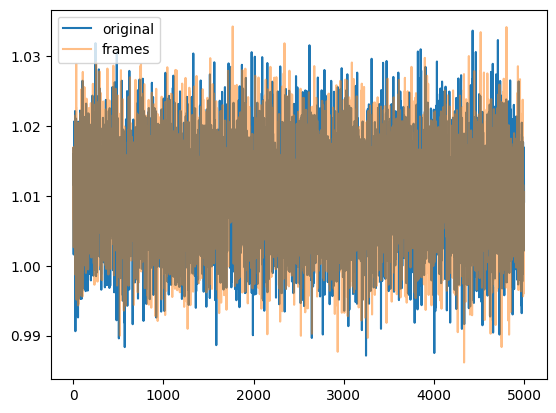

In [4]:
import matplotlib.pyplot as plt

plt.plot(range(5000), pct.history["PermShk"].mean(axis=1), label="original")
plt.plot(range(5000), pcft.history["PermShk"].mean(axis=1), label="frames", alpha=0.5)
plt.legend()

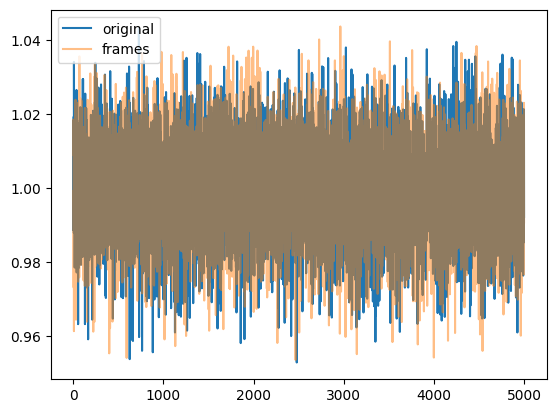

In [5]:
plt.plot(range(5000), pct.history["TranShk"].mean(axis=1), label="original")
plt.plot(range(5000), pcft.history["TranShk"].mean(axis=1), label="frames", alpha=0.5)
plt.legend()

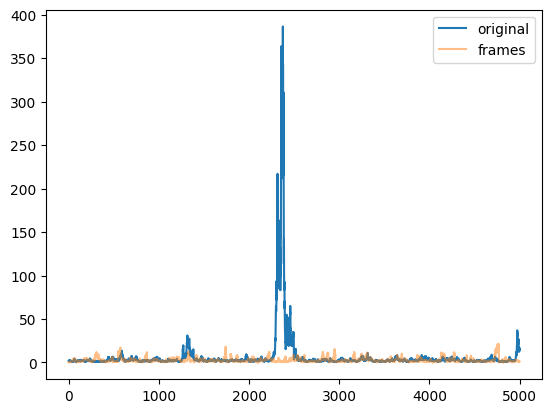

In [6]:
plt.plot(range(5000), pct.history["bNrm"].mean(axis=1), label="original")
plt.plot(range(5000), pcft.history["bNrm"].mean(axis=1), label="frames", alpha=0.5)
plt.legend()

In [7]:
# plt.plot(range(5000), pct.history['Risky'].mean(axis=1), label = 'original')
# plt.plot(range(5000), pcft.history['Risky'].mean(axis=1), label = 'frames', alpha = 0.5)
# plt.legend()

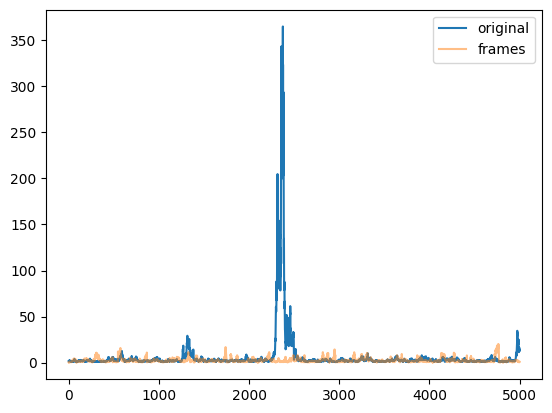

In [8]:
plt.plot(range(5000), pct.history["aNrm"].mean(axis=1), label="original")
plt.plot(range(5000), pcft.history["aNrm"].mean(axis=1), label="frames", alpha=0.5)
plt.legend()

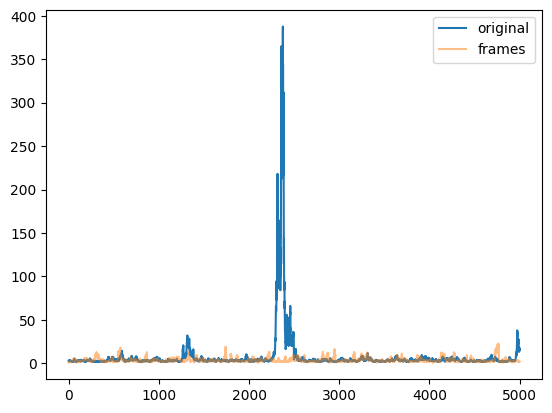

In [9]:
plt.plot(range(5000), pct.history["mNrm"].mean(axis=1), label="original")
plt.plot(range(5000), pcft.history["mNrm"].mean(axis=1), label="frames", alpha=0.5)
plt.legend()

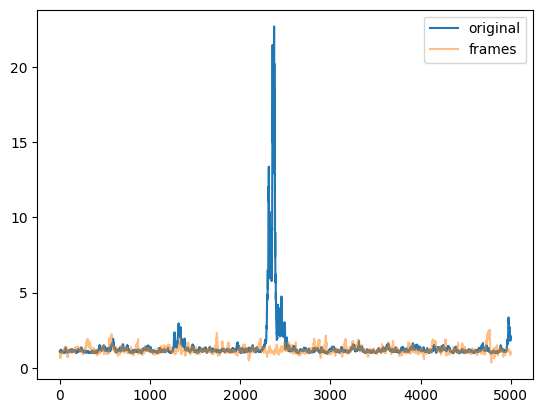

In [10]:
plt.plot(range(5000), pct.history["cNrm"].mean(axis=1), label="original")
plt.plot(range(5000), pcft.history["cNrm"].mean(axis=1), label="frames", alpha=0.5)
plt.legend()

**TODO**: Handly Risky as an aggregate value.

In [11]:
# pct.history['Risky'][:3, :3]

In [12]:
# pcft.history['Risky'][:3, :3]

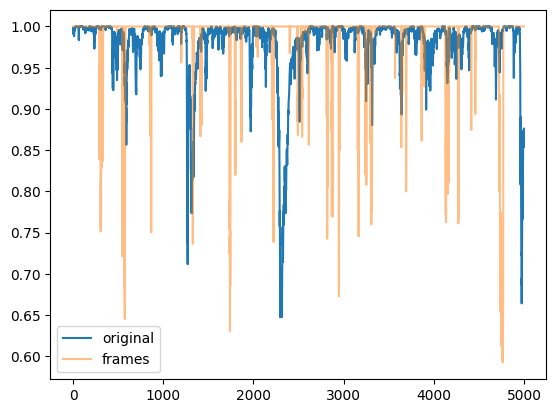

In [13]:
plt.plot(range(5000), pct.history["Share"].mean(axis=1), label="original")
plt.plot(range(5000), pcft.history["Share"].mean(axis=1), label="frames", alpha=0.5)
plt.legend()

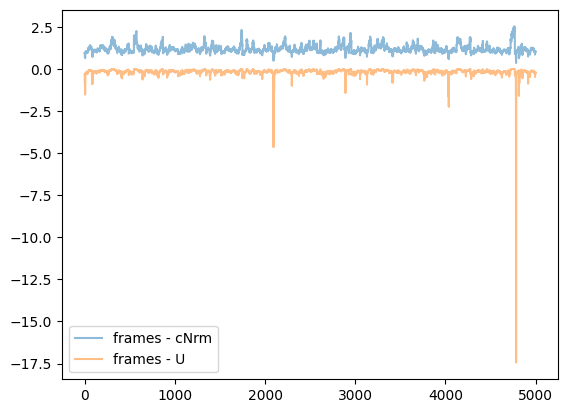

In [14]:
plt.plot(
    range(5000),
    pcft.history["cNrm"].mean(axis=1),
    label="frames - cNrm",
    alpha=0.5,
)
plt.plot(range(5000), pcft.history["U"].mean(axis=1), label="frames - U", alpha=0.5)
plt.legend()

In [15]:
pcft.history["U"]

array([[-0.32163767, -0.32163767, -0.32163767, ..., -0.32163767,
        -0.32163767, -0.32163767],
       [-0.29964502, -0.29964502, -0.29964502, ..., -0.29964502,
        -0.29964502, -0.29964502],
       [-0.31259768, -0.31259768, -0.31259768, ..., -0.31259768,
        -0.31259768, -0.31259768],
       ...,
       [-0.25024318, -0.25024318, -0.25024318, ..., -0.25024318,
        -0.25024318, -0.25024318],
       [-0.19620811, -0.19620811, -0.19620811, ..., -0.19620811,
        -0.19620811, -0.19620811],
       [-0.22725778, -0.22725778, -0.22725778, ..., -0.22725778,
        -0.22725778, -0.22725778]])

In [16]:
pcft.history["U"].mean(axis=1)

array([-0.32163767, -0.29964502, -0.31259768, ..., -0.25024318,
       -0.19620811, -0.22725778])

In [17]:
pcft.history["U"][0, :]

array([-0.32163767, -0.32163767, -0.32163767, -0.32163767, -0.32163767,
       -0.32163767, -0.32163767, -0.32163767, -0.32163767, -0.32163767,
       -0.32163767, -0.32163767, -0.32163767, -0.32163767, -0.32163767,
       -0.32163767, -0.32163767, -0.32163767, -0.32163767, -0.32163767,
       -0.32163767, -0.32163767, -0.32163767, -0.32163767, -0.32163767,
       -0.32163767, -0.32163767, -0.32163767, -0.32163767, -0.32163767,
       -0.32163767, -0.32163767, -0.32163767, -0.32163767, -0.32163767,
       -0.32163767, -0.32163767, -0.32163767, -0.32163767, -0.32163767,
       -0.32163767, -0.32163767, -0.32163767, -0.32163767, -0.32163767,
       -0.32163767, -0.32163767, -0.32163767, -0.32163767, -0.32163767,
       -0.32163767, -0.32163767, -0.32163767, -0.32163767, -0.32163767,
       -0.32163767, -0.32163767, -0.32163767, -0.32163767, -0.32163767,
       -0.32163767, -0.32163767, -0.32163767, -0.32163767, -0.32163767,
       -0.32163767, -0.32163767, -0.32163767, -0.32163767, -0.32

In [18]:
pcft.history["cNrm"][0, :]

array([0.93895175, 0.93895175, 0.93895175, 0.93895175, 0.93895175,
       0.93895175, 0.93895175, 0.93895175, 0.93895175, 0.93895175,
       0.93895175, 0.93895175, 0.93895175, 0.93895175, 0.93895175,
       0.93895175, 0.93895175, 0.93895175, 0.93895175, 0.93895175,
       0.93895175, 0.93895175, 0.93895175, 0.93895175, 0.93895175,
       0.93895175, 0.93895175, 0.93895175, 0.93895175, 0.93895175,
       0.93895175, 0.93895175, 0.93895175, 0.93895175, 0.93895175,
       0.93895175, 0.93895175, 0.93895175, 0.93895175, 0.93895175,
       0.93895175, 0.93895175, 0.93895175, 0.93895175, 0.93895175,
       0.93895175, 0.93895175, 0.93895175, 0.93895175, 0.93895175,
       0.93895175, 0.93895175, 0.93895175, 0.93895175, 0.93895175,
       0.93895175, 0.93895175, 0.93895175, 0.93895175, 0.93895175,
       0.93895175, 0.93895175, 0.93895175, 0.93895175, 0.93895175,
       0.93895175, 0.93895175, 0.93895175, 0.93895175, 0.93895175,
       0.93895175, 0.93895175, 0.93895175, 0.93895175, 0.93895

In [19]:
pcft.parameters["CRRA"]

5.0

In [20]:
CRRAutility(pcft.history["cNrm"][0, :], 5)

array([-0.32163767, -0.32163767, -0.32163767, -0.32163767, -0.32163767,
       -0.32163767, -0.32163767, -0.32163767, -0.32163767, -0.32163767,
       -0.32163767, -0.32163767, -0.32163767, -0.32163767, -0.32163767,
       -0.32163767, -0.32163767, -0.32163767, -0.32163767, -0.32163767,
       -0.32163767, -0.32163767, -0.32163767, -0.32163767, -0.32163767,
       -0.32163767, -0.32163767, -0.32163767, -0.32163767, -0.32163767,
       -0.32163767, -0.32163767, -0.32163767, -0.32163767, -0.32163767,
       -0.32163767, -0.32163767, -0.32163767, -0.32163767, -0.32163767,
       -0.32163767, -0.32163767, -0.32163767, -0.32163767, -0.32163767,
       -0.32163767, -0.32163767, -0.32163767, -0.32163767, -0.32163767,
       -0.32163767, -0.32163767, -0.32163767, -0.32163767, -0.32163767,
       -0.32163767, -0.32163767, -0.32163767, -0.32163767, -0.32163767,
       -0.32163767, -0.32163767, -0.32163767, -0.32163767, -0.32163767,
       -0.32163767, -0.32163767, -0.32163767, -0.32163767, -0.32

# Visualizing the Transition Equations

Note that in the HARK `ConsIndShockModel`, from which the `ConsPortfolio` model inherits, the aggregate permanent shocks are considered to be portions of the permanent shocks experienced by the agents, not additions to those idiosyncratic shocks. Hence, they do not show up directly in the problem solved by the agent. This explains why the aggregate income levels are in a separarte component of the graph.

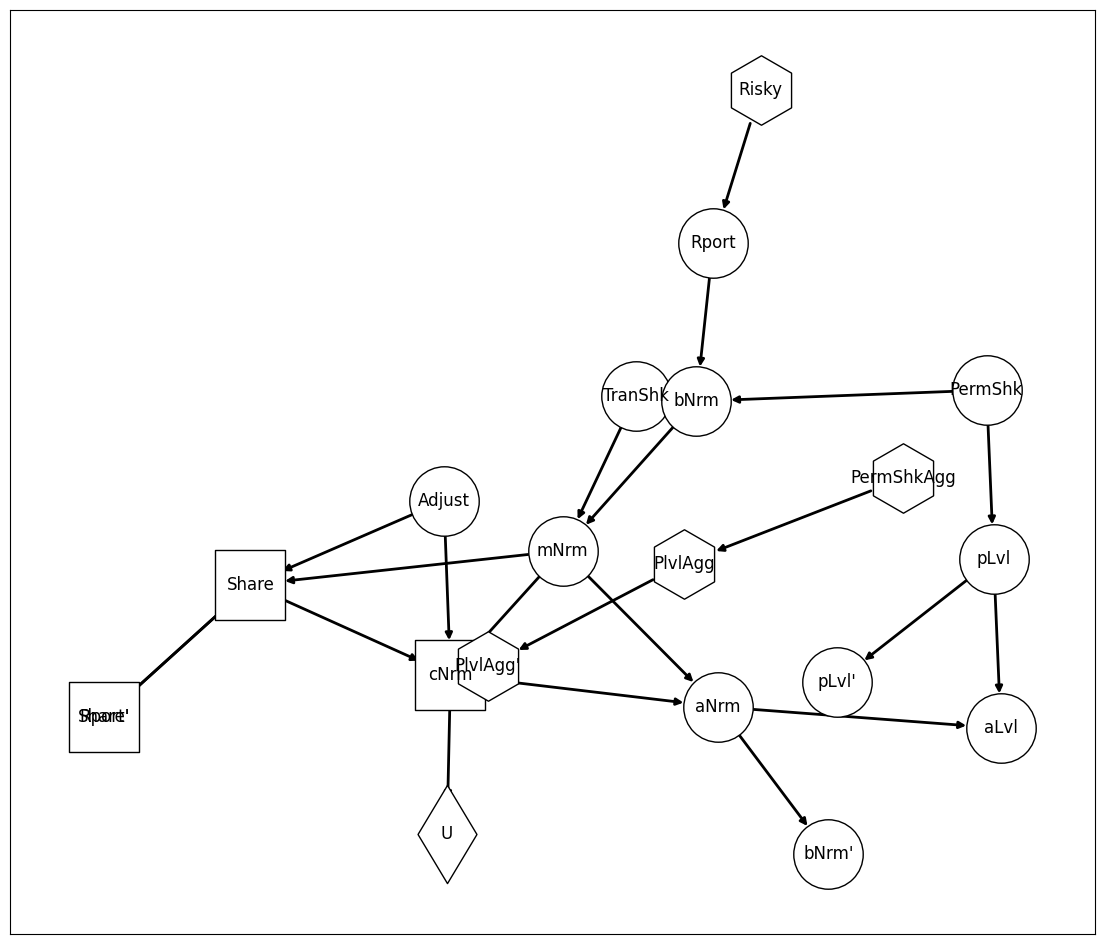

In [21]:
draw_frame_model(pcft.model, figsize=(14, 12))

# Building the Solver [INCOMPLETE]

Preliminery work towards a generic solver for FramedAgentTypes.

In [22]:
controls = [frame for frame in pcft.frames.values() if frame.control]

In [23]:
def get_expected_return_function(control: Frame):
    # Input: a control frame
    # Returns: function of the control variable (control frame target)
    #      that returns the expected return, which is
    #          the sum of:
    #              - direct rewards
    #              - expected value of next-frame states (not yet implemented)
    #

    rewards = [child for child in control.children if child.reward]
    expected_values = []  # TODO

    ## note: function signature is what's needed for scipy.optimize
    def expected_return_function(x, *args):
        ##   returns the sum of
        ##     the reward functions evaluated in context of
        ##       - parameters
        ##       - the control variable input

        # x - array of inputs, here the control frame target
        # args - a tuple of other parameters needed to complete the function

        expected_return = 0

        for reward in rewards:
            ## TODO: figuring out the ordering of `x` and `args` needed for multiple downstream scopes

            local_context = {}

            # indexing through the x and args values
            i = 0
            num_control_vars = None

            # assumes that all frame scopes list model variables first, parameters later
            # should enforce or clarify at the frame level.
            for var in reward.scope:
                if var in control.target:
                    local_context[var] = x[i]
                    i = i + 1
                elif var in pcft.parameters:
                    if num_control_vars is None:
                        num_control_vars = i

                    local_context[var] = args[i - num_control_vars]
                    i = i + 1

            # can `self` be implicit here?
            expected_return += reward.transition(reward, **local_context)

        return expected_return

    return expected_return_function

In [24]:
def optimal_policy_function(control: Frame):
    erf = get_expected_return_function(control)
    constraints = (
        control.constraints
    )  ## these will reference the context of the control transition, including scope

    ## Returns function:
    ##   input: control frame scope
    ##   output: result of scipy.optimize of the erf with respect to constraints
    ##           getting the optimal input (control variable) value
    return func

In [25]:
def approximate_optimal_policy_function(control, grid):
    ## returns a new function:
    ##   that is an interpolation over optimal_policy_function
    ##   over the grid

    return func